In [1]:
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pymc as pm

# move to previouse directory to access the privugger code
import os, sys
sys.path.append(os.path.join("../../"))

if os.uname().machine == 'arm64':
    raise Exception("Wrong Architecture: opendp.smartnoise.core library is not available on ARM64 architecture")

import privugger as pv

# Example of using Privugger on OpenDP 

This tutorial shows the use of privugger on a program using the differential privacy libray [OpenDP](https://github.com/opendp).

## OpenDP program

We consider a program that takes as input a dataset with attributes: age, sex, education, race, income and marriage status. The program outputs the mean of the incomes and adds Laplacian noise to protect the individuals privacy.

For each attribute, the program takes a parameter of type array (int or float) with the attribute value for each individual in the dataset. For example, to model a dataset of size 2 where the first individual is 20 and the second is 40, we set the `age` input parameter as `age=[20,40]`. The remaining parameters are defined in the same way. The last parameter `N` indicates the number of records in the dataset.

This way of defining the input may seem unnatural, but, as we will see below, it allows for a structured manner to specify the prior of the program.

Below we show two programs that compute the differentially private mean income. The programs are equivalent, but they illustrate different ways of using opendp:

* `dp_program` - It uses directly the input array `income`. In this program, we only need to use `opendp` to clamp and set the size of the data.

* `dp_program_csv` - The program illustrates the use of privugger for programs working on a `pandas` dataframe. First, it uses the input parameters to build a pandas dataframe (lines before `## Aftr here the...`). Then the program works directly on the dataframe. This program uses three extra `opendp` functions to parse the dataset.

  Note that `dp_program_csv` illustrates the use of `privugger` for any program working on a dataset. The part of the code after the comment `## After here the...` can contain arbitrary code working on a pandas dataframe.

Note that both programs include the opendp imports inside the function definition. This is required for any program using external libraries.

In [2]:
# TODO: rewrite the explanation above (if this programs work)
def dp_program(age, sex, educ, race, income, married):
    from opendp.trans import make_sized_bounded_mean, make_clamp, make_bounded_resize
    from opendp.meas import make_base_laplace
    from opendp.mod import enable_features
    enable_features("floating-point", "contrib")

    Δ = 10000./income.size
    ϵ = .1
    
    query = make_clamp((0., 10000.)) >> \
            make_bounded_resize(size=100, bounds=(0.,10000.), constant=0.0) >> \
            make_sized_bounded_mean(size=100, bounds=(0.,10000.)) >> \
            make_base_laplace(scale=Δ/ϵ)

    return np.float64(query(income))

def dp_program_csv(age, sex, educ, race, income, married):
    from opendp.trans import make_sized_bounded_mean, make_bounded_resize, \
                            make_clamp, make_split_dataframe, \
                            make_select_column, make_cast_default
    from opendp.meas import make_base_laplace
    from opendp.mod import enable_features
    enable_features("floating-point", "contrib")
    import pandas as pd

    # building .csv file with data in parameters
    # each sample generates a dataset
    temp_file='temp.csv'
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    df.to_csv(temp_file,header=None,index=False)
    
    # After here the program works on a pandas dataframe
    
    
    ## preparing string for opendp parsing
    with open(temp_file) as input_file:
        data = input_file.read()

    Δ = 10000./income.size
    ϵ = .1
        
    ## opendp parsing/casting/query
    query = make_split_dataframe(separator=",", col_names=var_names) >> \
            make_select_column(key="income", TOA=str) >> \
            make_cast_default(TIA=str, TOA=float) >> \
            make_clamp((0., 10000.)) >> \
            make_bounded_resize(size=income.size, bounds=(0.,10000.), constant=0.0) >> \
            make_sized_bounded_mean(size=income.size, bounds=(0.,10000.)) >> \
            make_base_laplace(scale=Δ/ϵ)
    
    return np.float64(query(data))

## Input specification

The next step is to specify the prior knowledge of the attacker using probability distributions (i.e., they are defined as _random variables_). In this example, we show specify each of the attributes that conform the dataset.

The variable `N` defines the size of the dataset. In this example, we consider a dataset of size 150.

For non-numeric attributes such as `sex`, `educ` or `race` we use distribution over natural numbers with each number denoting a category. We treat them as nominal values (i.e., we assume there is not order relation, $\leq$ among them). For these attributes (and `married`) we specify a uniform distribution over all possible categories.

For `age`, we set a binomial distribution prior with support 0 to 120; this distribution gives highest probability to ages close to 60 years old. We remark here that this prior may be refined by using statistical data about age data.

Finally, `income` is distributed according to a Normal distribution with mean 100 and standard deviation 5. This gives high probability to values close to 100 (i.e., 100k DKK).

In [3]:
N         = 150
age       = pv.Binomial('age', p=0.5, n=120, num_elements=N)
sex       = pv.DiscreteUniform('sex', 0,2,num_elements=N)
educ      = pv.DiscreteUniform('educ', 0,10, num_elements=N)
race      = pv.DiscreteUniform('race', 0,50, num_elements=N)
income    = pv.Normal('income', mu=100, std=5, num_elements=N)
married   = pv.DiscreteUniform('married', 0,1,num_elements=N)

## Dataset & Program specification  

The input specification above is always wrapped into a `Dataset` object. This object is used as the input for the program.

In [4]:
ds = pv.Dataset(input_specs = [age, sex, educ, race, income, married])

## Program specification

The program specification takes the `Dataset` above and the program to analyze. To this end, we define a `Program` object including the `Dataset`, a python function corresponding to the program to analyze (the input parameters of the function must match those of the `Dataset`). Finally, it is necessary to specify the type of the output of the program. In this case, since we are analyzing a program compute the mean income, it is a float. The first parameter of the `Program` constructor is the name of the output distribution (i.e., the distribution of the output of the program under analysis).

We run the analysis for `dp_program_csv`. But feel free to re-run the analysis with `dp_program`, the results should not vary.

In [5]:
program = pv.Program('output',dataset=ds, output_type=pv.Float, function=dp_program_csv)

## Inference

Lastly we use the privug interface to perform the inference. This is done by calling `infer` and specifying the `program`, number of cores, number of chains, number of draws, and the backend (which is pymc3 in this example).

In [6]:
trace = pv.infer(program, cores=4, chains=2, draws=2000, method='pymc3')

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [age]
>>Metropolis: [sex]
>>Metropolis: [educ]
>>Metropolis: [race]
>>Metropolis: [married]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 139 seconds.


## Privacy Risk Analysis

### Mutual Information

To quantify privacy risks, in this tutorial we are using mutual information (though we remark here that privugger can be used to compute many more leakage measures).

We study the risks for the individual in the first record. We compute the mutual information between the output of the program (mean income + laplace noise) and each of the other attributes in the dataset.

Since the mutual informaiton estimator we use is not exact, we compute 100 estimates and use box plots to get an impresison of the accuracy of the estimates.

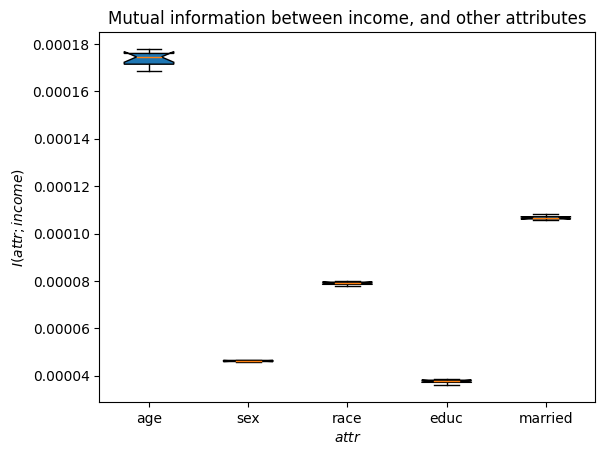

In [7]:
attrs=['age','sex','race','educ','married']

y=[[pv.mi_sklearn(trace, var_names=[attr,'income'],n_neigh=40,input_inferencedata=True)[0]
    for attr in attrs] for i in range(0,10)]

plt.boxplot(np.array(y),attrs,showmeans=False, showfliers=False, patch_artist=True,vert=True)
plt.xticks(range(1,len(attrs)+1), attrs)
plt.xlabel('$attr$')
plt.ylabel('$I(attr;income)$')
plt.title("Mutual information between income, and other attributes")
plt.show()

In the figure above, we observe that the mutual information between the output and any of the attributes is very low $I(\mathit{attr};\mathit{output})\leq 0.0002$ for all attributes ($\mathit{attr}$).